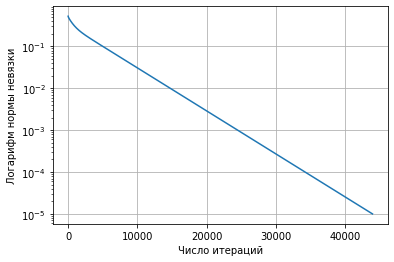

In [34]:
# Градиентный спуск с постоянным шагом

import numpy as np
import math
import random
import matplotlib.pyplot as plt

N = 9 
eps = 10**(-5)

U = np.random.sample((N, N))
Q = np.linalg.qr(U)[0]
D = np.zeros((N, N))
for i in range(N):
    D[i][i] = i**2 + 1
A = ((Q.transpose()).dot(D)).dot(Q)
b = np.random.sample(N)
x = np.zeros(N)

opt = np.linalg.solve(A, b)

M = (A.transpose()).dot(A)
d = (A.transpose()).dot(b)

h = 1/max(np.linalg.eigvals(M))

r = []
g = M.dot(x) - d
norm = np.linalg.norm(x - opt)
while norm > eps:
    r.append(norm)
    g = M.dot(x) - d
    norm = np.linalg.norm(x - opt)
    x = x - h*g
    
fig, ax = plt.subplots()
ax.semilogy(r)

ax.set(xlabel='Число итераций', ylabel='Логарифм нормы невязки')
ax.grid()
#fig.savefig("test1.eps")

In [35]:
X = np.zeros(N*N)
K = -np.ones((N, N))
for i in range(N):
    K[i][i] += N
W = np.kron(K, np.eye(N))
D = np.diag([i**0.5 for i in np.linalg.eig(W)[0]])
V = np.linalg.eig(W)[1]
W2 = V.dot(D).dot(np.linalg.inv(V)).real
U = np.zeros(N*N)
alpha = 10
beta = 10
h = 0.03

plot1 = []

W2

array([[ 2.66666667e+00, -1.37504797e-09, -1.72288877e-10, ...,
        -1.62319401e-10, -8.72270305e-11, -1.36170921e-11],
       [ 0.00000000e+00,  2.66666667e+00,  3.83343857e-10, ...,
         8.23212957e-11, -1.20516208e-11, -3.22736442e-11],
       [ 0.00000000e+00, -2.60045660e-16,  2.66666667e+00, ...,
        -8.17463631e-10, -1.33105252e-11,  2.22921740e-10],
       ...,
       [ 0.00000000e+00, -2.31526144e-16, -1.41735399e-10, ...,
         2.66666667e+00, -4.50283116e-11, -6.68047576e-11],
       [ 0.00000000e+00, -1.97601770e-16, -9.03782798e-11, ...,
         1.10638920e-09,  2.66666667e+00, -3.00004439e-10],
       [ 0.00000000e+00, -1.26337292e-16, -1.11630054e-10, ...,
         1.22048971e-09,  1.31141317e-10,  2.66666667e+00]])

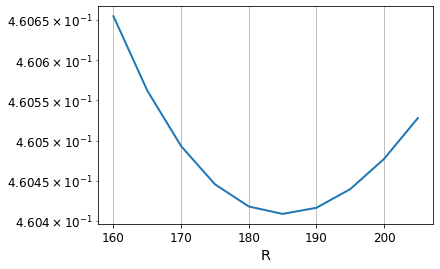

In [38]:
# Переход к композитной оптимизации + децентрализация

sol = np.linalg.solve(A, b)

def test_R(R):
    X = np.zeros(N*N)

    L = -np.ones((N, N))
    for i in range(N):
        L[i][i] += N
    W = np.kron(L, np.eye(N))

    err = []

    for i in range(1000):
        current_err = []
        for j in range(N):
            cW = W2[::,N*j:N*j+N]
            aTa = np.array([[A[j][p]*A[j][q] for p in range(N)] for q in range(N)])
            eigv = [abs(i) for i in np.linalg.eigvals(aTa + R*(cW.transpose()).dot(cW))]
            h = 1/max(eigv)
            grad = aTa.dot(X[N*j:N*j+N]) + R*(cW.transpose()).dot(W2.dot(X)) - b[j]*A[j]
            X[N*j:N*j+N] = X[N*j:N*j+N] - h*grad
            current_err.append(np.linalg.norm(X[N*j:N*j+N] - sol))
        err.append(max(current_err))
    return err[-1]

err1 = []
R1 = []
for i in range(10):
    R = 160.0 + 5*i 
    R1.append(R)
    err1.append(test_R(R))
    
#fig, ax = plt.subplots()
plt.semilogy(R1, err1, lw = 2)

plt.xlabel('R', fontsize = 'x-large')
plt.grid()
plt.tick_params(axis = 'both', which = 'both', labelsize = 12)
plt.savefig("R_81.eps")

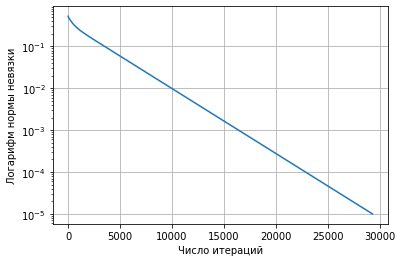

In [39]:
sol = np.linalg.solve(A, b)
R = 185.0
X = np.zeros(N*N)

L = -np.ones((N, N))
for i in range(N):
    L[i][i] += N
W = np.kron(L, np.eye(N))

err = []
err_WX = []

aTa_list = [np.array([[A[j][p]*A[j][q] for p in range(N)] for q in range(N)]) for j in range(N)]

while True:
    current_err = []
    for j in range(N):
        cW = W2[::,N*j:N*j+N]
        aTa = aTa_list[j]
        eigv = np.linalg.eigvals(aTa + R*(cW.transpose()).dot(cW))
        eigv = [abs(i) for i in eigv]
        h = 1/max(eigv)
        grad = (A[j].dot(X[N*j:N*j+N]))*A[j] + R*(cW.transpose()).dot(W2.dot(X)) - b[j]*A[j]
        X[N*j:N*j+N] = X[N*j:N*j+N] - h*grad
        current_err.append(np.linalg.norm(X[N*j:N*j+N] - sol))
    err.append(max(current_err))    
    err_WX.append(np.linalg.norm(W2.dot(X)))
    if err[-1] < eps:
        break
        
err_par = [err[i] for i in range(len(err)) if i % N == 0]

fig, ax = plt.subplots()
ax.semilogy(err_par)

ax.set(xlabel='Число итераций', ylabel='Логарифм нормы невязки')
ax.grid()
fig.savefig("test3.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


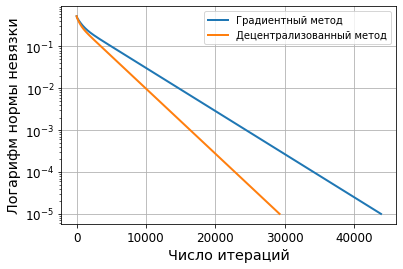

In [40]:
#plt.semilogy(r, 'b', err_par, 'r')
#fig, ax = plt.subplots()
plt.semilogy(r, label = 'Градиентный метод', lw = 2)
plt.semilogy(err_par, label = 'Децентрализованный метод', lw = 2)

plt.xlabel('Число итераций', fontsize = 'x-large')
plt.ylabel('Логарифм нормы невязки', fontsize = 'x-large')
plt.grid()

plt.legend()
plt.tick_params(axis = 'both', which = 'both', labelsize = 12)
plt.savefig("Copm_81.eps")